# Document Summarization

## Referene

- http://www.orsj.or.jp/archive2/or62-11/or62_11_711.pdf

## McDonald model (2007)

Variables:

- $x_{i}$: 1 if the summarized text includes sentence $i$, 0 otherwise.
- $K$: the maximum length of summarized text.
- $c_{i}$: the length of sentence $i$.
- $r_{i}$: the dgree of similarity between sentence $i$ and the whole text.
- $s_{ij}$: the dgree of similarity between sentence $i$ and sentence $j$.

Minimize:

$$
f(q) = -\sum_{i=1}^N r_{i} x_{i} + \lambda \sum_{i < j} s_{ij} x_{i} x_{j}
$$

Suject to:

$$
\sum_{i=1}^N c_{i} x_{i} \leq K
$$

## QUBO formulation

The following formulation is

$$
f(\mathbf{x}) = -\sum_{i=1}^N r_{i}x_{i} + \alpha \sum_{i < j} s_{ij} x_{i}x_{j}
+ \lambda_1 \left( \sum_{i=1}^N c_{i}x_{i} - \sum_{i=1}^N i y_i \right)^2 + \lambda_2 \left( \sum_{i=1}^N y_i - 1 \right)^2
$$

where the inequality constraint on the length of summarized text is expressed by using auxiliary variables $\mathbf{y}$ and penalty method.

The linear expression for the inequality constraint can also work by adjusting the amplitude $\lambda$ to meet it.

$$
f(\mathbf{x}) = -\sum_{i=1}^N r_{i} x_{i} + \alpha \sum_{i < j} s_{ij} x_{i}x_{j}
+ \lambda \sum_{i=1}^N c_i x_i
$$

In [1]:
# Steve Jobs' Commencement address (2005)
path_data = '../data/english_text.txt'

with open(path_data, 'r') as f:
    original_text = f.read()

print(original_text[:1000])

Thank you. I'm honored to be with you today for your commencement from one of the finest universities in the world. Truth be told, I never graduated from college and this is the closest I've ever gotten to a college graduation.

Today I want to tell you three stories from my life. That's it. No big deal. Just three stories. The first story is about connecting the dots.

I dropped out of Reed College after the first six months but then stayed around as a drop-in for another eighteen months or so before I really quit. So why did I drop out? It started before I was born. My biological mother was a young, unwed graduate student, and she decided to put me up for adoption. She felt very strongly that I should be adopted by college graduates, so everything was all set for me to be adopted at birth by a lawyer and his wife, except that when I popped out, they decided at the last minute that they really wanted a girl. So my parents, who were on a waiting list, got a call in the middle of the ni

In [2]:
from nltk.tokenize import sent_tokenize
# import nltk
# nltk.download('punkt')

morphemes = sent_tokenize(original_text)

In [3]:
import numpy as np

def create_bow(morphemes):
    word2id = {}
    for line in morphemes:
        for word in line.split():
            if word in word2id:
                continue
            word2id[word] = len(word2id)

    bow_set = []
    for line in morphemes:
        bow = [0] * len(word2id)
        for word in line.split():
            try:
                bow[word2id[word]] += 1
            except:
                pass
        bow_set.append(bow)
    
    return bow_set

def cos_sim(bow1, bow2):
    narr_bow1 = np.array(bow1)
    narr_bow2 = np.array(bow2)
    return np.sum(narr_bow1 * narr_bow2) / (np.linalg.norm(narr_bow1) * np.linalg.norm(narr_bow2))

bow_set = create_bow(morphemes)
bow_all = np.sum(bow_set, axis=0)
sim2all = [cos_sim(b, bow_all) for b in bow_set]
sim2each = [[cos_sim(b, c) if i < j else 0 for j, c in enumerate(bow_set)] for i, b in enumerate(bow_set)]

num_sentences = len(morphemes)
sentence_lengths = np.array([len(m) for m in morphemes])
sentence_lengths = sentence_lengths / np.max(sentence_lengths)

In [4]:
from pyqubo import Array, Placeholder

def create_pyqubo_model(num_sentences, sim2all, sim2each, sentence_lengths):
    x = Array.create(name='x', shape=num_sentences, vartype='BINARY')
    H = - np.sum([sim2all[i] * x[i] for i in range(num_sentences)])
    H += Placeholder('alpha') * np.sum([sim2each[i][j] * x[i] * x[j] for i in range(num_sentences) for j in range(i+1, num_sentences)])
    H += Placeholder('lam') * np.sum([sentence_lengths[i] * x[i] for i in range(num_sentences)])

    return H.compile()

model = create_pyqubo_model(num_sentences, sim2all, sim2each, sentence_lengths)

In [5]:
feed_dict = dict(alpha=1.0, lam=0.5)
bqm = model.to_bqm(index_label=True, feed_dict=feed_dict)

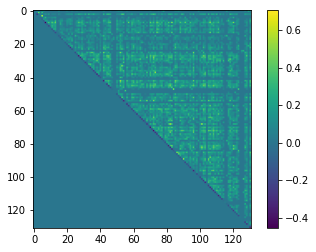

In [6]:
import matplotlib.pyplot as plt

plt.imshow(bqm.to_numpy_matrix().astype(float))
plt.colorbar()
plt.show()

In [7]:
from neal import SimulatedAnnealingSampler

sampleset = SimulatedAnnealingSampler().sample(bqm, num_reads=10)

In [8]:
def sampleset_to_text(sampleset, var_name='x'):
    decoded_samples = model.decode_sampleset(sampleset, feed_dict=feed_dict)
    summarized_texts = []
    for sample in decoded_samples:
        texts = []
        for i in range(len(sample.sample)):
            if sample.sample[f'{var_name}[{i}]'] == 1:
                texts.append(morphemes[i])
        summarized_texts.append(texts)
    return summarized_texts

summarized_texts = sampleset_to_text(sampleset)
print(' '.join(summarized_texts[0]))
print(len(summarized_texts[0]))

Thank you. That's it. This was the start in my life. It wasn't all romantic. My second story is about love and loss. How can you get fired from a company you started? I still loved what I did. The turn of events at Apple had not changed that one bit. Don't settle. It's life's change agent; it clears out the old to make way for the new. Sorry to be so dramatic, but it's quite true.
11
